In [1]:
!pip install keras

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')
# Load the dataset
data = pd.read_csv('hypothyroidd.csv')

# 1. Data Cleaning - Replace '?' with NaN for easier handling
data.replace('?', np.nan, inplace=True)

# 2. Converting 'sex' column to binary (female -> 0, male -> 1)
data['sex'] = data['sex'].map({'F': 0, 'M': 1})

# 3. Handling missing values (using median as a simple approach)
numerical_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric
    median_value = data[col].median()  # Calculate median
    data[col].fillna(median_value, inplace=True)  # Fill missing values

# 4. Convert binary columns (e.g., 't'/'f' to 1/0)
binary_columns = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick',
                  'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid',
                  'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
                  'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
                  'FTI_measured', 'TBG_measured']
data[binary_columns] = data[binary_columns].applymap(lambda x: 1 if x == 't' else 0)

# 5. Determine if the patient is hypothyroid based on 'binaryClass'
data['hypothyroid'] = data['binaryClass'].map({'P': 1, 'N': 0})



In [3]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,binaryClass,hypothyroid
0,41,0.0,0,0,0,0,0,0,0,0,...,125.0,1,1.14,1,109.0,0,NaN,SVHC,P,1
1,23,0.0,0,0,0,0,0,0,0,0,...,102.0,0,0.98,0,107.0,0,NaN,other,P,1
2,46,1.0,0,0,0,0,0,0,0,0,...,109.0,1,0.91,1,120.0,0,NaN,other,P,1
3,70,0.0,1,0,0,0,0,0,0,0,...,175.0,0,0.98,0,107.0,0,NaN,other,P,1
4,70,0.0,0,0,0,0,0,0,0,0,...,61.0,1,0.87,1,70.0,0,NaN,SVI,P,1


In [4]:
data = data.drop('TBG', axis=1)

In [5]:
data = data.drop('referral_source', axis=1)

In [6]:
data['sex'] = data['sex'].replace('?', np.nan)  # Replace '?' with NaN
data['sex'] = data['sex'].fillna(method='ffill')  # Forward fill NaN values


In [7]:
data['age'] = data['age'].replace('?', np.nan)  # Replace '?' with NaN
data['age'] = data['age'].fillna(method='ffill')  # Forward fill NaN values

In [8]:
data['binaryClass'] = data['binaryClass'].map({'P': 1, 'N': 0})

In [9]:
data.isnull().sum()

,0
age,0
sex,0
on_thyroxine,0
query_on_thyroxine,0
on_antithyroid_medication,0
sick,0
pregnant,0
thyroid_surgery,0
I131_treatment,0
query_hypothyroid,0


In [10]:
data.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'binaryClass', 'hypothyroid'],
      dtype='object')

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
# Import train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Splitting the data
X = data.drop('binaryClass', axis=1)
y = data['binaryClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
from sklearn.model_selection import cross_val_score

nb_model = GaussianNB(var_smoothing=1e-2)
scores = cross_val_score(nb_model, X, y, cv=10, scoring='accuracy')
print("Cross-validated scores:", scores)
print("accuracy:", scores.mean())
import numpy as np

best_var_smoothing = 0
best_score = 0

for smoothing in np.logspace(0,-9, num=100):
    nb_model = GaussianNB(var_smoothing=smoothing)
    scores = cross_val_score(nb_model, X, y, cv=10, scoring='accuracy')
    if scores.mean() > best_score:
        best_score = scores.mean()
        best_var_smoothing = smoothing



# Train with the best var_smoothing
nb_model = GaussianNB(var_smoothing=best_var_smoothing)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

Cross-validated scores: [0.94708995 0.94708995 0.94429708 0.94429708 0.95225464 0.93103448
 0.9469496  0.9602122  0.96816976 0.95490716]
accuracy: 0.9496301910095015


In [12]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,binaryClass,hypothyroid
0,41,0.0,0,0,0,0,0,0,0,0,...,2.5,1,125.0,1,1.14,1,109.0,0,1,1
1,23,0.0,0,0,0,0,0,0,0,0,...,2.0,1,102.0,0,0.98,0,107.0,0,1,1
2,46,1.0,0,0,0,0,0,0,0,0,...,2.0,1,109.0,1,0.91,1,120.0,0,1,1
3,70,0.0,1,0,0,0,0,0,0,0,...,1.9,1,175.0,0,0.98,0,107.0,0,1,1
4,70,0.0,0,0,0,0,0,0,0,0,...,1.2,1,61.0,1,0.87,1,70.0,0,1,1


In [13]:
!pip install tensorflow

In [14]:
!pip install scikit-learn

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE



# Address data imbalance using SMOTE (oversampling)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Class distribution in training set (after SMOTE):", Counter(y_train_resampled))

# ANN model with adjusted complexity and dropout
ann_model = Sequential()
ann_model.add(Dense(16, input_dim=X_train_resampled.shape[1], activation='relu'))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(8, activation='relu'))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train and predict with reduced epochs and larger batch size
ann_model.fit(X_train_resampled, y_train_resampled, epochs=30, batch_size=20, verbose=0)  # Reduced epochs and increased batch size
ann_pred = (ann_model.predict(X_test) > 0.5).astype("int32")

# Evaluation
ann_accuracy = accuracy_score(y_test, ann_pred)
ann_precision = precision_score(y_test, ann_pred, average='weighted')
ann_recall = recall_score(y_test, ann_pred, average='weighted')
ann_f1 = f1_score(y_test, ann_pred, average='weighted')
ann_roc = roc_auc_score(y_test, ann_pred)
ann_error = np.mean(ann_pred.flatten() != y_test)

print(f"ANN - Accuracy: {ann_accuracy}, Precision: {ann_precision}, Recall: {ann_recall}, F1 Score: {ann_f1}, ROC AUC: {ann_roc}, Error Rate: {ann_error}")


Class distribution in training set (after SMOTE): Counter({1: 2784, 0: 2784})
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
ANN - Accuracy: 0.9814569536423841, Precision: 0.9850625459896982, Recall: 0.9814569536423841, F1 Score: 0.982361366438533, ROC AUC: 0.9899569583931134, Error Rate: 0.018543046357615896


In [16]:
# Example new patient data
new_patient_data = {
    'age': [45], 'sex': [0], 'on_thyroxine': [0], 'query_on_thyroxine': [0], 'on_antithyroid_medication': [0],
    'sick': [0], 'pregnant': [0], 'thyroid_surgery': [0], 'I131_treatment': [0], 'query_hypothyroid': [0],
    'query_hyperthyroid': [0], 'lithium': [0], 'goitre': [0], 'tumor': [0], 'hypopituitary': [0], 'psych': [0],
    'TSH_measured': [1], 'TSH': [1.3], 'T3_measured': [1], 'T3': [1.3], 'TT4_measured': [1], 'TT4': [12],
    'T4U_measured': [1], 'T4U': [1.01], 'FTI_measured': [1], 'FTI': [10], 'TBG_measured': [0], 'binaryClass': [1],
    'hypothyroid' : [1]
}

# Create DataFrame
new_data = pd.DataFrame(new_patient_data)

# Get the feature names used during training for ANN model (assuming same as XGBoost)
training_features_ann = X_train.columns # Replace with the training data used for the ANN

# Adding missing columns with default values and ensuring the correct order
for feature in training_features_ann:
    if feature not in new_data.columns:
        new_data[feature] = 0  # Or an appropriate default value

# Reorder columns to match training data for ANN (if needed)
new_data = new_data[training_features_ann]

ann_prediction = ann_model.predict(new_data)
ann_result = 'positive' if ann_prediction > 0.5 else 'negative'
print("ANN Model Prediction:\n The patient has hypothyroid : ",ann_result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
ANN Model Prediction:
 The patient has hypothyroid :  positive


Epoch 1/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5265 - loss: 5.4417
Epoch 2/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5703 - loss: 1.0498
Epoch 3/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5750 - loss: 0.7451
Epoch 4/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6143 - loss: 0.6674
Epoch 5/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6619 - loss: 0.6026
Epoch 6/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7149 - loss: 0.5578
Epoch 7/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7698 - loss: 0.4914
Epoch 8/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8284 - loss: 0.4124
Epoch 9/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8958 - loss: 0.2643
Epoch 10/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9417 - loss: 0.1991
Epoch 11/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9572 - loss: 0.1528
Epoch 12/50
557/557 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

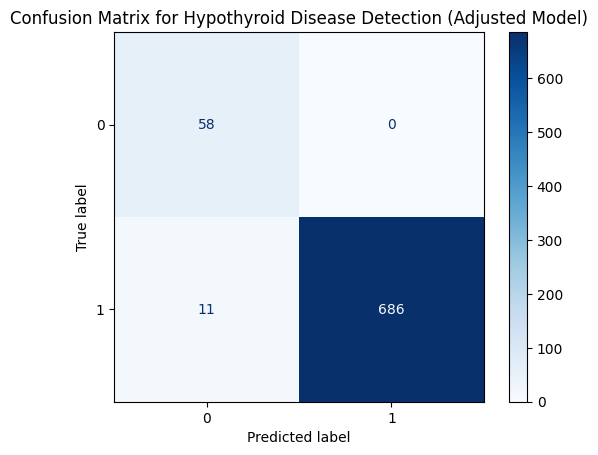

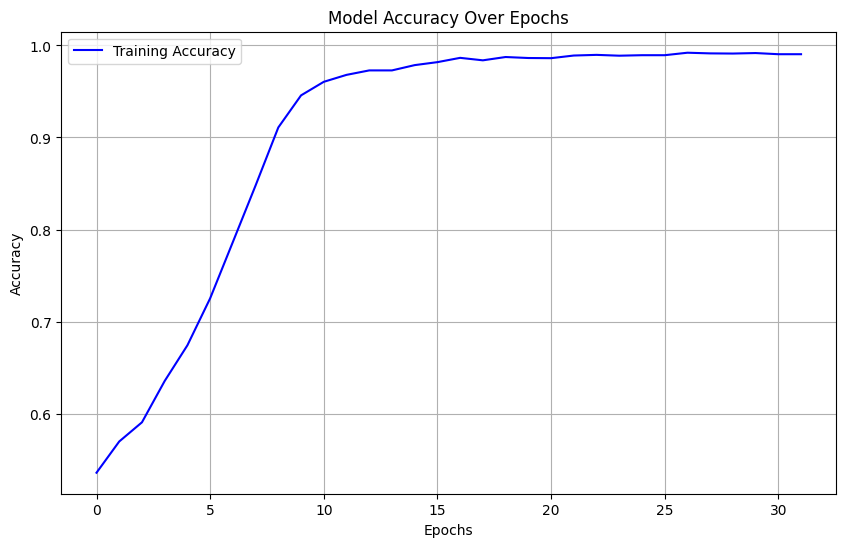

In [17]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Build ANN model
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
ann_model.add(Dropout(0.4))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dropout(0.4))
ann_model.add(Dense(16, activation='relu'))
ann_model.add(Dropout(0.4))
ann_model.add(Dense(1, activation='sigmoid'))

ann_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

# Train model with class weights
history = ann_model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=10, verbose=1,
                        class_weight=class_weights_dict, callbacks=[early_stopping])

# Adjust prediction threshold and evaluate
threshold = 0.7
ann_pred = (ann_model.predict(X_test) > threshold).astype("int32")

# Confusion Matrix and evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, ann_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap='Blues')
plt.title("Confusion Matrix for Hypothyroid Disease Detection (Adjusted Model)")
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [18]:
!pip install keras tensorflow

In [19]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [20]:
data.isnull().sum()

,0
age,0
sex,0
on_thyroxine,0
query_on_thyroxine,0
on_antithyroid_medication,0
sick,0
pregnant,0
thyroid_surgery,0
I131_treatment,0
query_hypothyroid,0


In [21]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

# Encoding target variable if it's multiclass
label_encoder = LabelEncoder()
y_multiclass = label_encoder.fit_transform(data['binaryClass'])

# Convert 'age' column to numeric before splitting
data['age'] = pd.to_numeric(data['age'], errors='coerce')

# Feature Engineering (Example: Create interaction term)
# Replace with relevant features from your data
data['age_sex_interaction'] = data['age'] * data['sex']

# Select features and target
X = data[['age', 'sex', 'age_sex_interaction', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'thyroid_surgery', 'query_hypothyroid',
       'query_hyperthyroid', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre',
       'TSH_measured', 'TSH', 'T3_measured', 'T3', 'TT4_measured', 'TT4',
       'T4U_measured', 'T4U', 'FTI_measured', 'FTI', 'TBG_measured'
       ]]
y = y_multiclass

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross-validation with StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_model = None
best_accuracy = 0

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    xgb_model = XGBClassifier(
    scale_pos_weight=1,
    max_depth=2,  # Reduced further
    learning_rate=0.01,  # Reduced
    n_estimators=50,  # Reduced
    objective='binary:logistic',
    subsample=0.7,  # Added subsampling
    colsample_bytree=0.7,  # Added column subsampling
    gamma=1  # Added regularization
)
    xgb_model.fit(X_train_fold, y_train_fold)

    y_pred_val = xgb_model.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred_val)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = xgb_model

# Prediction using the best model
y_pred = best_model.predict(X_test)

# Evaluation
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 0.9231788079470199
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        58
           1       0.92      1.00      0.96       697

    accuracy                           0.92       755
   macro avg       0.46      0.50      0.48       755
weighted avg       0.85      0.92      0.89       755



In [22]:
!pip install scikit-learn

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Splitting features and target with reduced feature set
X = data[['age', 'TSH', 'T3']]  # Reduced number of features
y = data['binaryClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Instantiate the Random Forest Classifier with more conservative parameters
rf_classifier = RandomForestClassifier(
    n_estimators=10,        # Fewer trees
    max_depth=5,            # Shallower trees
    min_samples_split=15,   # Require more samples to split
    min_samples_leaf=10,    # More samples per leaf
    random_state=42
)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf))



Accuracy: 97.88%
Random Forest Classifier Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        58
           1       0.99      0.98      0.99       697

    accuracy                           0.98       755
   macro avg       0.91      0.95      0.93       755
weighted avg       0.98      0.98      0.98       755



In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Evaluation Metrics
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

Precision: 0.8522591114424806
Recall: 0.9231788079470199
F1 Score: 0.886302519475307


In [26]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('hypothyroidd.csv')

# 1. Data Cleaning - Replace '?' with NaN for easier handling
data.replace('?', np.nan, inplace=True)

# 2. Converting 'sex' column to binary (female -> 0, male -> 1)
data['sex'] = data['sex'].map({'F': 0, 'M': 1})

# 3. Handling missing values (using median as a simple approach)
numerical_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric
    median_value = data[col].median()  # Calculate median
    data[col].fillna(median_value, inplace=True)  # Fill missing values

# 4. Convert binary columns (e.g., 't'/'f' to 1/0)
binary_columns = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick',
                  'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid',
                  'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
                  'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
                  'FTI_measured', 'TBG_measured']
data[binary_columns] = data[binary_columns].applymap(lambda x: 1 if x == 't' else 0)

# 5. Determine if the patient is hypothyroid based on 'binaryClass'
data['hypothyroid'] = data['binaryClass'].map({'P': 1, 'N': 0})

# Preparing the data for the model
X = data[['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'on_thyroxine', 'query_on_thyroxine',
          'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
          'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
          'psych']]
y = data['hypothyroid']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer 1
model.add(Dense(16, activation='relu'))  # Hidden layer 2
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)

# Threshold values for hormone levels
TSH_threshold = 5.0  # mIU/L
T3_threshold = 80     # ng/dL
T4_threshold = 5.0    # μg/dL
FTI_threshold = 0.7   # ng/dL
T4U_threshold = 0.8   # ng/dL
TSH_threshold_high = 4.0  # mIU/L
TSH_threshold_low = 0.4    # mIU/L (Normal lower limit)

# Function to predict hypothyroidism using the trained ANN
def predict_hypothyroid(age, sex, TSH, T3, TT4, T4U, FTI, on_thyroxine, query_on_thyroxine,
                        on_antithyroid_medication, sick, pregnant, thyroid_surgery, I131_treatment,
                        query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, hypopituitary, psych):

    # Prepare the input data in the format the model expects
    input_data = np.array([[age, sex, TSH, T3, TT4, T4U, FTI, on_thyroxine, query_on_thyroxine,
                            on_antithyroid_medication, sick, pregnant, thyroid_surgery, I131_treatment,
                            query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, hypopituitary, psych]])

    # Check for hypothyroidism
    if TSH > TSH_threshold and T3 < T3_threshold and TT4 < T4_threshold and FTI < FTI_threshold and T4U < T4U_threshold:
        # Determine the type of hypothyroidism based on TSH levels
        if TSH > 10:
            hypo_type = "Primary Hypothyroidism"
        elif 5.0 <= TSH <= 10.0:
            hypo_type = "Intermediate Hypothyroidism"
        else:
            hypo_type = "Secondary Hypothyroidism"
        return "The patient has hypothyroidism.", hypo_type

    # Check for Secondary Hypothyroidism specifically
    elif TSH < TSH_threshold_low and T3 < T3_threshold and TT4 < T4_threshold:
        return "The patient has hypothyroidism.", "Secondary Hypothyroidism"

    # No hypothyroidism detected
    else:
        return "The patient does not have hypothyroidism.", "N/A"

# Customizing the UI with interactive components and better visuals
inputs = [
    gr.Slider(0, 100, label="Age", value=30, step=1, info="Enter the patient's age"),
    gr.Radio([0, 1], label="Sex (0: Female, 1: Male)", value=0, info="Select patient's sex"),
    gr.Slider(0.0, 20.0, label="TSH", value=2.0, step=0.1, info="Thyroid-Stimulating Hormone level"),
    gr.Slider(0.0, 300.0, label="T3", value=100.0, step=1.0, info="Triiodothyronine level (ng/dL)"),
    gr.Slider(0.0, 10.0, label="T4", value=7.0, step=0.1, info="Total Thyroxine level (μg/dL)"),
    gr.Slider(0.0, 30.0, label="FTI", value=1.0, step=0.1, info="Free Thyroxine Index (ng/dL)"),
    gr.Slider(0.0, 10.0, label="T4U", value=1.0, step=0.1, info="Thyroxine-Binding Globulin (ng/dL)"),
    gr.Checkbox(label="On Thyroxine", info="Check if patient is on Thyroxine"),
    gr.Checkbox(label="Query On Thyroxine", info="Check if Thyroxine is being queried"),
    gr.Checkbox(label="On Antithyroid Medication", info="Check if patient is on Antithyroid medication"),
    gr.Checkbox(label="Sick", info="Check if the patient is sick"),
    gr.Checkbox(label="Pregnant", info="Check if the patient is pregnant"),
    gr.Checkbox(label="Thyroid Surgery", info="Check if patient had thyroid surgery"),
    gr.Checkbox(label="I131 Treatment", info="Check if the patient had I131 treatment"),
    gr.Checkbox(label="Query Hypothyroid", info="Check if querying hypothyroidism"),
    gr.Checkbox(label="Query Hyperthyroid", info="Check if querying hyperthyroidism"),
    gr.Checkbox(label="Lithium", info="Check if patient is taking Lithium"),
    gr.Checkbox(label="Goitre", info="Check if patient has goitre"),
    gr.Checkbox(label="Tumor", info="Check if patient has a tumor"),
    gr.Checkbox(label="Hypopituitary", info="Check if patient has hypopituitarism"),
    gr.Checkbox(label="Psych", info="Check if patient has psychological issues")
]

# Creating separate output boxes, to be displayed after the "Submit" button is clicked
outputs = [
    gr.Textbox(label="Hypothyroid Prediction", info="Shows if the patient has hypothyroidism"),
    gr.Textbox(label="Hypothyroid Type", info="Shows the type of hypothyroidism if the patient is positive")
]

# Creating a Submit Button
gr_interface = gr.Interface(
    fn=predict_hypothyroid,
    inputs=inputs,
    outputs=outputs,
    title="Hypothyroid Disease Detection using ANN",
    description="Input the patient's clinical features to predict if they have hypothyroidism. This model is based on data from medical examinations.",
    theme="dark",  # Apply a dark theme for visual attractiveness
    live=False,  # Disable real-time predictions, submit button is required
    allow_flagging="never",  # Disable flagging feature for better UX
    css="""
    .gradio-container { font-family: Arial, sans-serif; color: white; padding: 20px; background-color: #2e2e2e; }
    """


)


# Launch the interface
gr_interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f664a7b59217f047ef.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


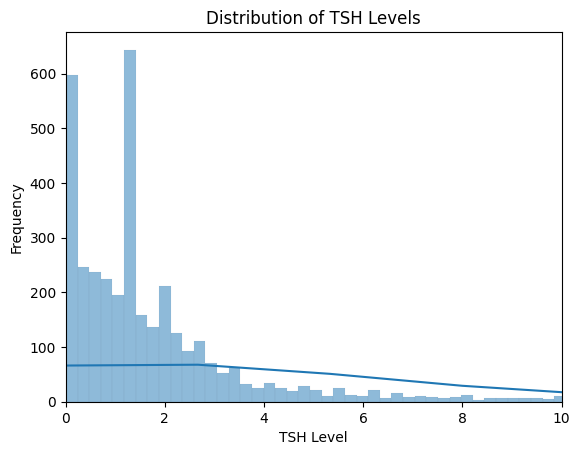

In [27]:
# Create the histogram with specified bins
sns.histplot(data['TSH'], kde=True)

# Set the x-axis limits to focus on the relevant range
plt.xlim(0, 10)  # Adjust the upper limit as needed

plt.title('Distribution of TSH Levels')
plt.xlabel('TSH Level')
plt.ylabel('Frequency')
plt.show()

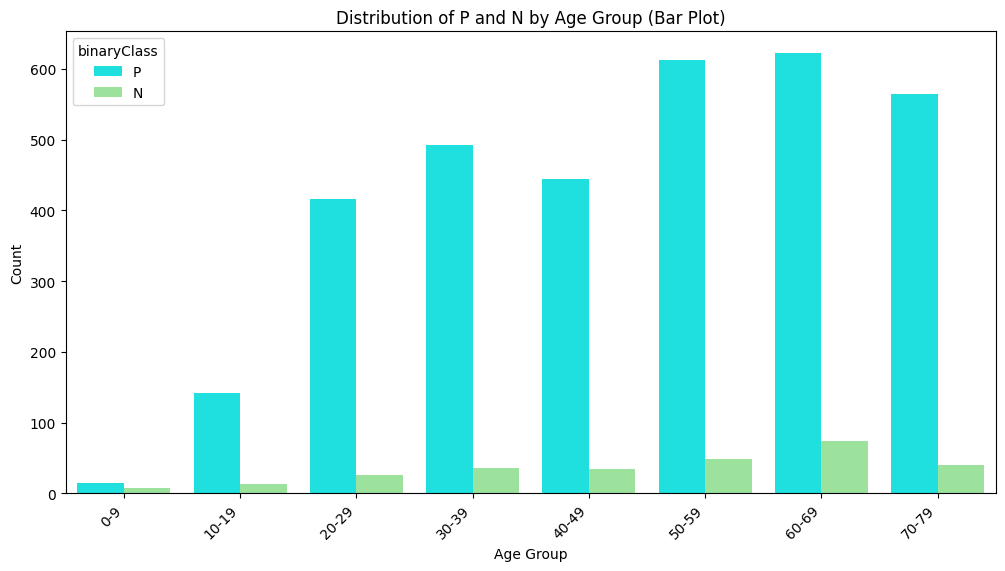

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define age groups
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79'] # Reduced by one label to match the number of bins

# Ensure 'age' column is numeric and handle potential errors
data['age'] = pd.to_numeric(data['age'], errors='coerce')  # Convert to numeric, invalid parsing will be set as NaN
data['age'].fillna(data['age'].median(), inplace=True)  # Fill NaN values with median age

# Create a new column with age groups
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

# Bar plot
plt.figure(figsize=(12, 6))
sns.countplot(x='age_group', hue='binaryClass', data=data, palette=['aqua', 'lightgreen'])
plt.title('Distribution of P and N by Age Group (Bar Plot)')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

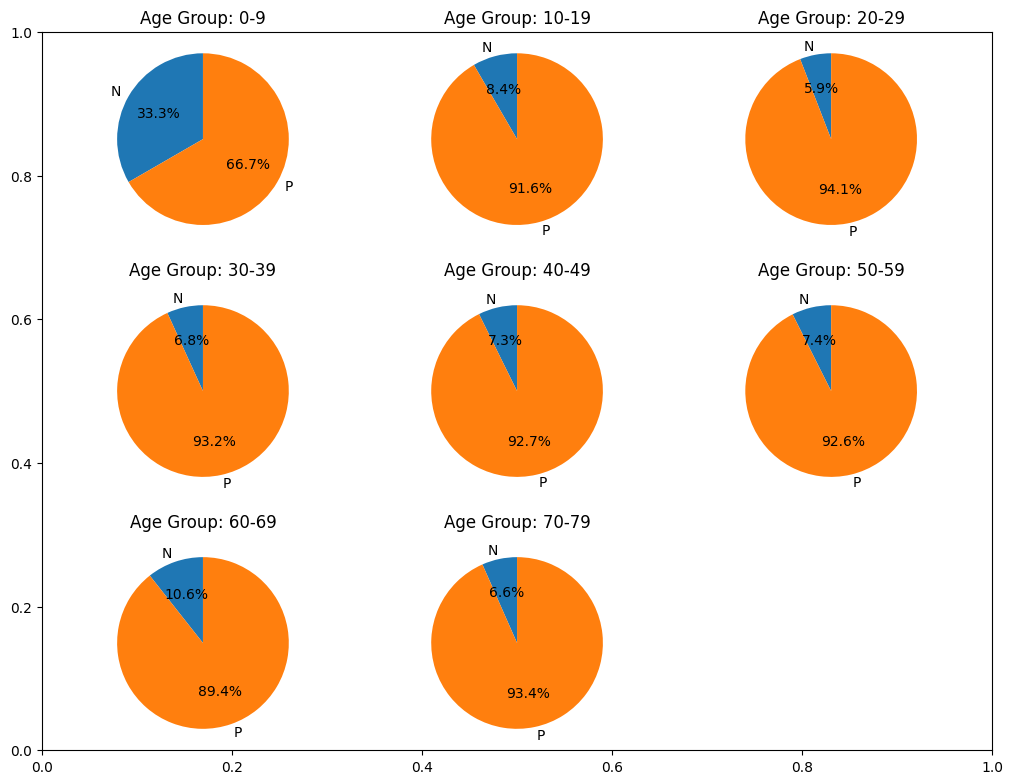

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame with 'age' and 'binaryClass' columns

# Define age groups
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

# Create a new column with age groups
data['age_group'] = pd.cut(data['age'], bins=age_bins, labels=age_labels, right=False)

# Group data by age group and binaryClass, then count occurrences
age_class_counts = data.groupby(['age_group', 'binaryClass'])['binaryClass'].count().unstack(fill_value=0)

# Create pie chart
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate through age groups and create pie subplots
for i, age_group in enumerate(age_labels):
    counts = age_class_counts.loc[age_group]
    ax = plt.subplot(3, 3, i + 1)  # Arrange subplots in a grid
    ax.pie(counts, labels=['N', 'P'], autopct='%1.1f%%', startangle=90)
    ax.set_title(f'Age Group: {age_group}')

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

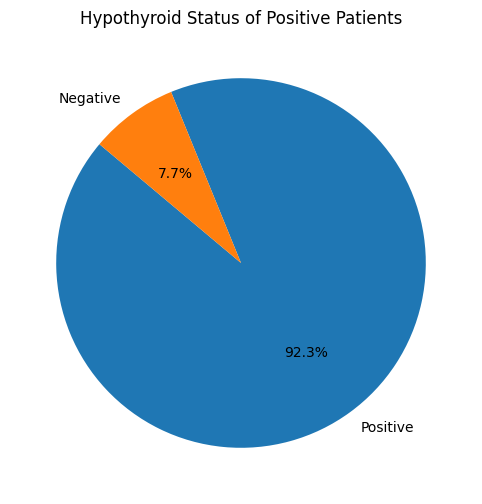

In [30]:
# Pie chart for the count of positive hypothyroid patients
plt.figure(figsize=(8, 6))
plt.pie(data['hypothyroid'].value_counts(), labels=['Positive', 'Negative'],
        autopct='%1.1f%%', startangle=140)
plt.title('Hypothyroid Status of Positive Patients')
plt.show()

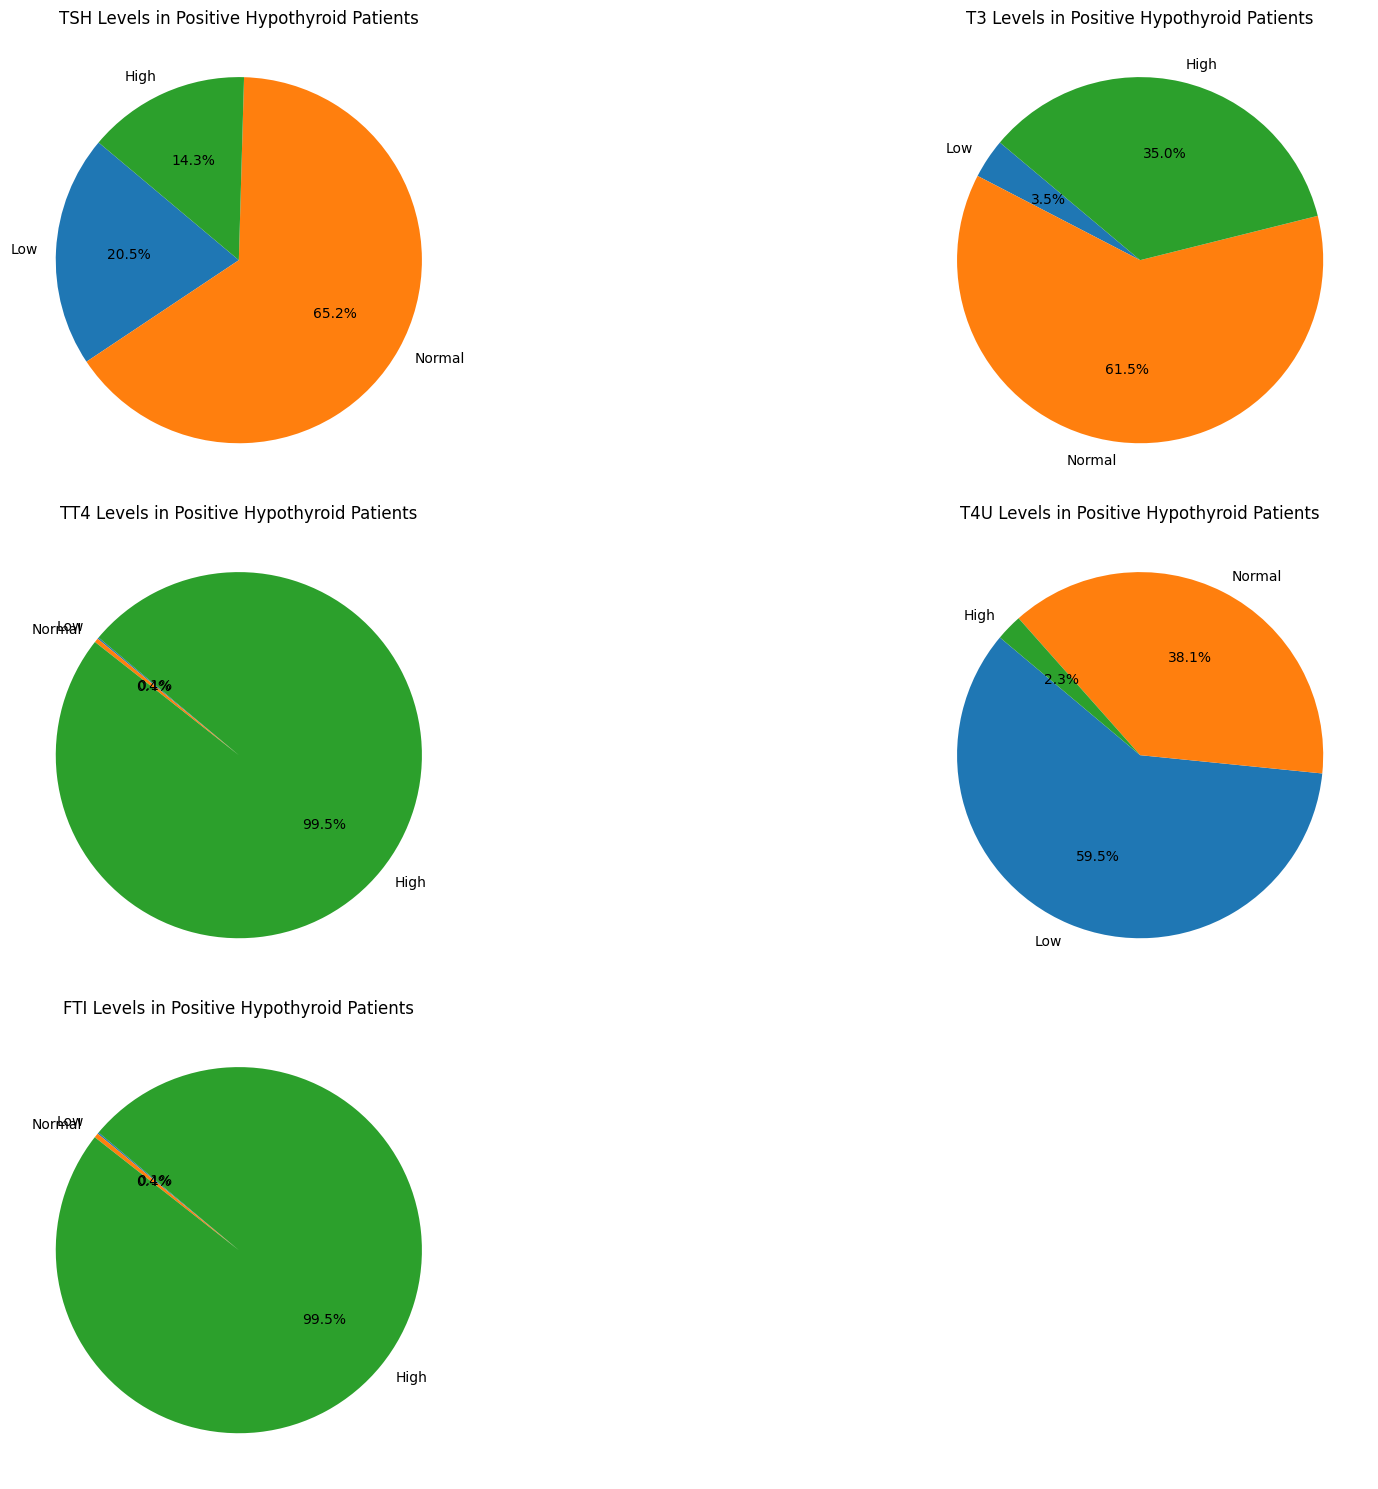

In [31]:
# Function to categorize test results
def categorize_levels(column, low_threshold, high_threshold):
    low_count = np.sum(column < low_threshold)
    normal_count = np.sum((column >= low_threshold) & (column <= high_threshold))
    high_count = np.sum(column > high_threshold)
    return [low_count, normal_count, high_count]

# Categories and thresholds for TSH, T3, TT4, T4U, and FTI
thresholds = {
    'TSH': (0.4, 4.0),   # TSH normal range
    'T3': (0.8, 2.0),    # T3 normal range
    'TT4': (4.5, 12.0),  # TT4 normal range
    'T4U': (1.0, 1.5),   # T4U normal range
    'FTI': (4.5, 12.0)   # FTI normal range
}

# Pie charts for each test result
plt.figure(figsize=(20, 15))

# TSH Levels
plt.subplot(3, 2, 1)
tsh_counts = categorize_levels(data['TSH'], *thresholds['TSH'])
plt.pie(tsh_counts, labels=['Low', 'Normal', 'High'], autopct='%1.1f%%', startangle=140)
plt.title('TSH Levels in Positive Hypothyroid Patients')

# T3 Levels
plt.subplot(3, 2, 2)
t3_counts = categorize_levels(data['T3'], *thresholds['T3'])
plt.pie(t3_counts, labels=['Low', 'Normal', 'High'], autopct='%1.1f%%', startangle=140)
plt.title('T3 Levels in Positive Hypothyroid Patients')

# TT4 Levels
plt.subplot(3, 2, 3)
tt4_counts = categorize_levels(data['TT4'], *thresholds['TT4'])
plt.pie(tt4_counts, labels=['Low', 'Normal', 'High'], autopct='%1.1f%%', startangle=140)
plt.title('TT4 Levels in Positive Hypothyroid Patients')

# T4U Levels
plt.subplot(3, 2, 4)
t4u_counts = categorize_levels(data['T4U'], *thresholds['T4U'])
plt.pie(t4u_counts, labels=['Low', 'Normal', 'High'], autopct='%1.1f%%', startangle=140)
plt.title('T4U Levels in Positive Hypothyroid Patients')

# FTI Levels
plt.subplot(3, 2, 5)
fti_counts = categorize_levels(data['FTI'], *thresholds['FTI'])
plt.pie(fti_counts, labels=['Low', 'Normal', 'High'], autopct='%1.1f%%', startangle=140)
plt.title('FTI Levels in Positive Hypothyroid Patients')

plt.tight_layout()
plt.show()

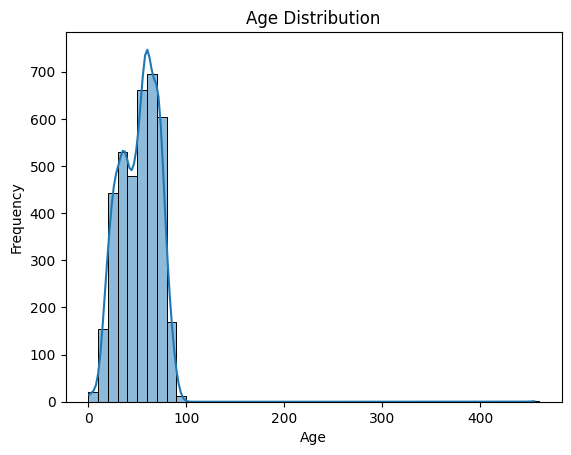

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the bin edges
bin_edges = np.arange(0, data['age'].max() + 10, 10)

# Create the histogram with specified bins
sns.histplot(data['age'], bins=bin_edges, kde=True)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()



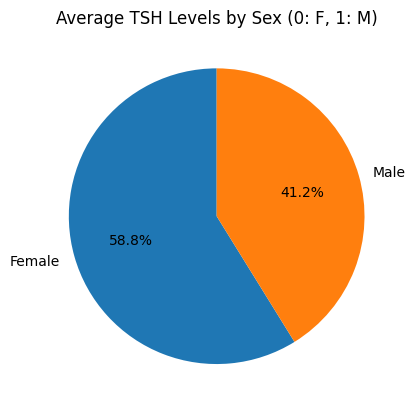

In [33]:
data_pie = data.copy()

# Replace 'F' with 0 and 'M' with 1 in the 'sex' column
data_pie['sex'] = data_pie['sex'].replace({0.0: 'Female', 1.0: 'Male'})

# Group data by sex and calculate the mean TSH for each group
sex_tsh = data_pie.groupby('sex')['TSH'].mean()

# Create the pie chart
plt.pie(sex_tsh, labels=sex_tsh.index, autopct='%1.1f%%', startangle=90)
plt.title('Average TSH Levels by Sex (0: F, 1: M)')  # Update title for clarity
plt.show()



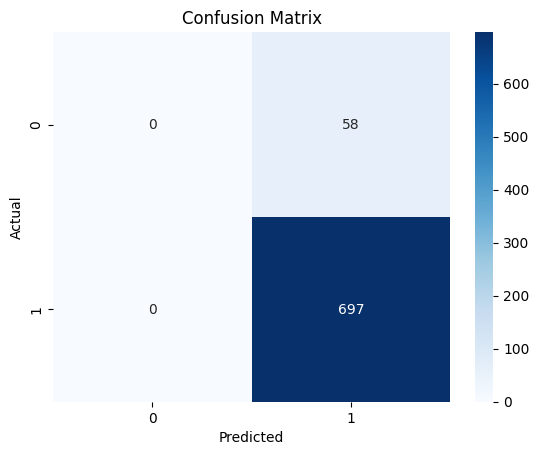

In [34]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [35]:
#optional
#data.drop(['age_sex_interaction'], axis=1,inplace=True)


data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,binaryClass,hypothyroid,age_group
0,41.0,0.0,0,0,0,0,0,0,0,0,...,1,1.14,1,109.0,0,NaN,SVHC,P,1,40-49
1,23.0,0.0,0,0,0,0,0,0,0,0,...,0,0.98,0,107.0,0,NaN,other,P,1,20-29
2,46.0,1.0,0,0,0,0,0,0,0,0,...,1,0.91,1,120.0,0,NaN,other,P,1,40-49
3,70.0,0.0,1,0,0,0,0,0,0,0,...,0,0.98,0,107.0,0,NaN,other,P,1,70-79
4,70.0,0.0,0,0,0,0,0,0,0,0,...,1,0.87,1,70.0,0,NaN,SVI,P,1,70-79


In [36]:
# 6. Classifying hypothyroid stage based on other values
def classify_hypothyroid(row):
    if row['hypothyroid'] == 0:
        return 'Negative'
    elif row['TSH'] > 4.0 and row['T3'] < 3.0:
        return 'Primary'
    elif row['TSH'] < 4.0 and row['T3'] < 3.0:
        return 'Secondary'
    else:
        return 'Compensated'

data['hypothyroid_stage'] = data.apply(classify_hypothyroid, axis=1)

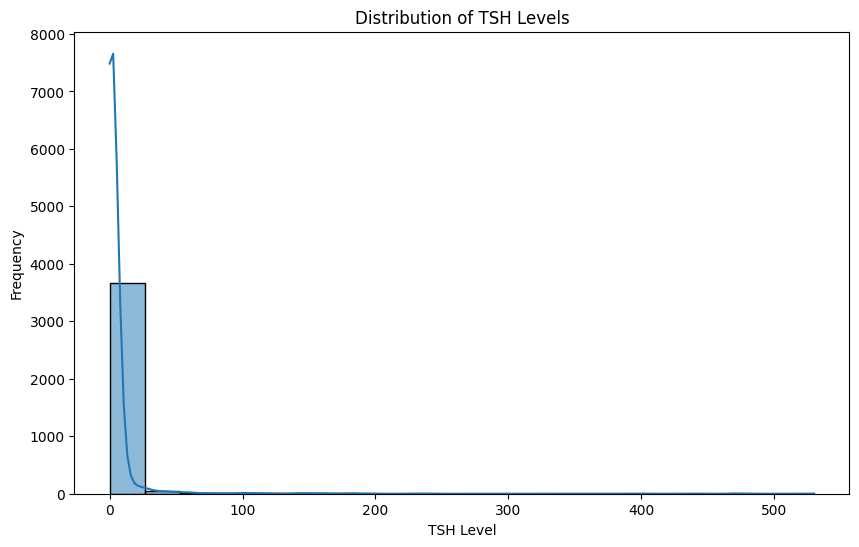

In [37]:
# Distribution of TSH levels
plt.figure(figsize=(10, 6))
sns.histplot(data['TSH'], bins=20, kde=True)
plt.title('Distribution of TSH Levels')
plt.xlabel('TSH Level')
plt.ylabel('Frequency')
plt.show()

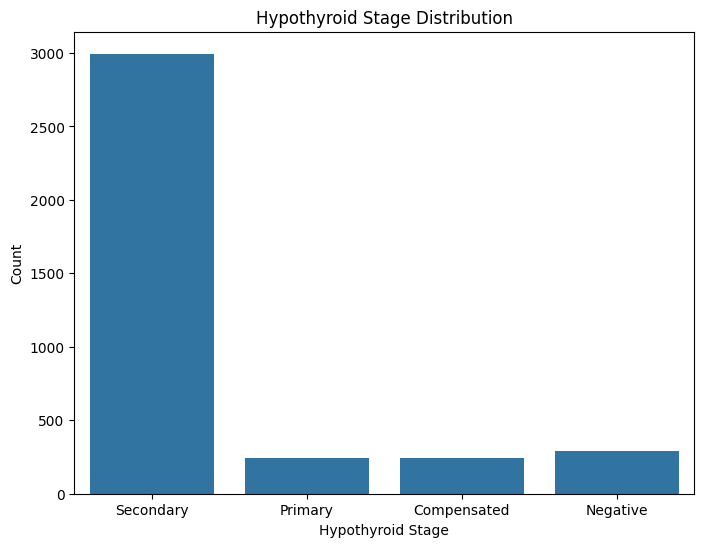

In [38]:
# Visualizing hypothyroid stages
plt.figure(figsize=(8, 6))
sns.countplot(x='hypothyroid_stage', data=data)
plt.title('Hypothyroid Stage Distribution')
plt.xlabel('Hypothyroid Stage')
plt.ylabel('Count')
plt.show()

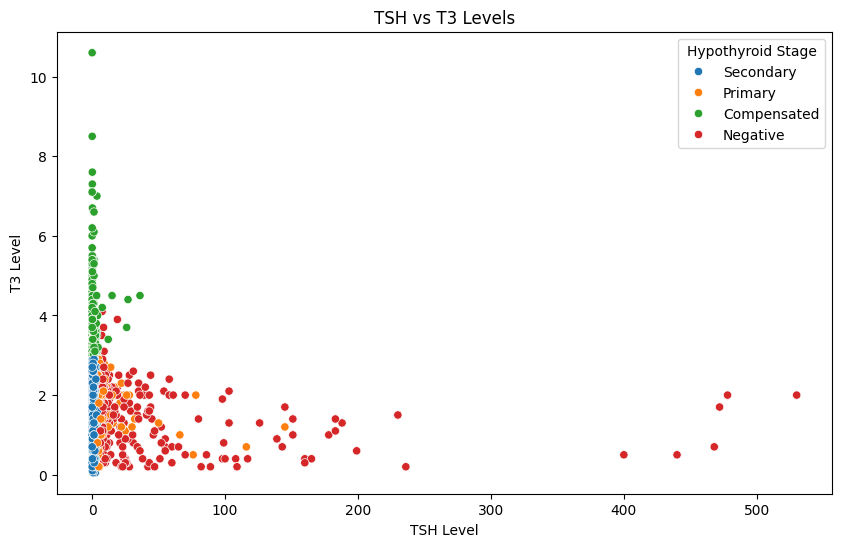

In [39]:
# Scatter plot to visualize TSH vs T3 levels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSH', y='T3', hue='hypothyroid_stage', data=data)
plt.title('TSH vs T3 Levels')
plt.xlabel('TSH Level')
plt.ylabel('T3 Level')
plt.legend(title='Hypothyroid Stage')
plt.show()

In [40]:
data.columns


Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'binaryClass', 'hypothyroid', 'age_group', 'hypothyroid_stage'],
      dtype='object')

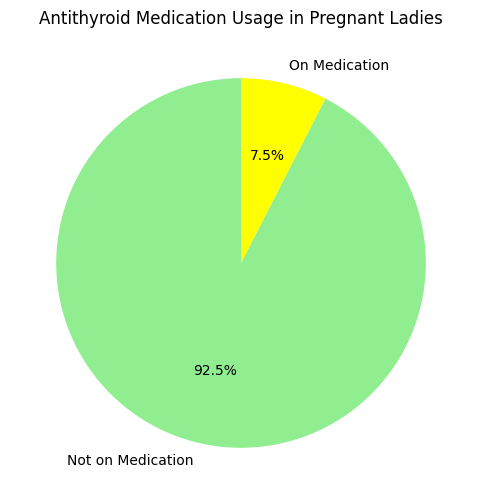

In [41]:
# Filter data for pregnant ladies
pregnant_data = data[data['pregnant'] == 1]

# Count whether patients are on antithyroid medication within pregnant ladies
medication_counts = pregnant_data['on_antithyroid_medication'].value_counts()

# If there are two unique values (0 and 1), proceed
if len(medication_counts) == 2:
    plt.figure(figsize=(6, 6))
    # Use custom labels for clarity
    plt.pie(medication_counts, labels=['Not on Medication', 'On Medication'],
            autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'yellow'])
    plt.title('Antithyroid Medication Usage in Pregnant Ladies')
    plt.show()
else:
    print("Insufficient data for creating a pie chart. Only one category found.")

In [43]:
import pandas as pd
import numpy as np
import gradio as gr
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('hypothyroidd.csv')

# 1. Data Cleaning - Replace '?' with NaN for easier handling
data.replace('?', np.nan, inplace=True)

# 2. Converting 'sex' column to binary (female -> 0, male -> 1)
data['sex'] = data['sex'].map({'F': 0, 'M': 1})

# 3. Handling missing values (using median as a simple approach)
numerical_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numerical_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Convert to numeric
    median_value = data[col].median()  # Calculate median
    data[col].fillna(median_value, inplace=True)  # Fill missing values

# 4. Convert binary columns (e.g., 't'/'f' to 1/0)
binary_columns = ['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick',
                  'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid',
                  'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
                  'psych', 'TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured',
                  'FTI_measured', 'TBG_measured']
data[binary_columns] = data[binary_columns].applymap(lambda x: 1 if x == 't' else 0)

# 5. Determine if the patient is hypothyroid based on 'binaryClass'
data['hypothyroid'] = data['binaryClass'].map({'P': 1, 'N': 0})

# Preparing the data for the model
X = data[['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'on_thyroxine', 'query_on_thyroxine',
          'on_antithyroid_medication', 'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
          'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary',
          'psych']]
y = data['hypothyroid']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the ANN model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer 1
model.add(Dense(16, activation='relu'))  # Hidden layer 2
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)

# Threshold values for hormone levels
TSH_threshold = 5.0  # mIU/L
T3_threshold = 80     # ng/dL
T4_threshold = 5.0    # μg/dL
FTI_threshold = 0.7   # ng/dL
T4U_threshold = 0.8   # ng/dL
TSH_threshold_high = 4.0  # mIU/L
TSH_threshold_low = 0.4    # mIU/L (Normal lower limit)

# Function to predict hypothyroidism using the trained ANN
def predict_hypothyroid(age, sex, TSH, T3, TT4, T4U, FTI, on_thyroxine, query_on_thyroxine,
                        on_antithyroid_medication, sick, pregnant, thyroid_surgery, I131_treatment,
                        query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, hypopituitary, psych):

    # Prepare the input data in the format the model expects
    input_data = np.array([[age, sex, TSH, T3, TT4, T4U, FTI, on_thyroxine, query_on_thyroxine,
                            on_antithyroid_medication, sick, pregnant, thyroid_surgery, I131_treatment,
                            query_hypothyroid, query_hyperthyroid, lithium, goitre, tumor, hypopituitary, psych]])

    # Check for hypothyroidism
    if TSH > TSH_threshold and T3 < T3_threshold and TT4 < T4_threshold and FTI < FTI_threshold and T4U < T4U_threshold:
        # Determine the type of hypothyroidism based on TSH levels
        if TSH > 10:
            hypo_type = "Primary Hypothyroidism"
        elif 5.0 <= TSH <= 10.0:
            hypo_type = "Intermediate Hypothyroidism"
        else:
            hypo_type = "Secondary Hypothyroidism"
        return "The patient has hypothyroidism.", hypo_type

    # Check for Secondary Hypothyroidism specifically
    elif TSH < TSH_threshold_low and T3 < T3_threshold and TT4 < T4_threshold:
        return "The patient has hypothyroidism.", "Secondary Hypothyroidism"

    # No hypothyroidism detected
    else:
        return "The patient does not have hypothyroidism.", "N/A"

# Customizing the UI with interactive components and better visuals
inputs = [
    gr.Slider(0, 100, label="Age", value=30, step=1, info="Enter the patient's age"),
    gr.Radio([0, 1], label="Sex (0: Female, 1: Male)", value=0, info="Select patient's sex"),
    gr.Slider(0.0, 20.0, label="TSH", value=2.0, step=0.1, info="Thyroid-Stimulating Hormone level"),
    gr.Slider(0.0, 300.0, label="T3", value=100.0, step=1.0, info="Triiodothyronine level (ng/dL)"),
    gr.Slider(0.0, 10.0, label="T4", value=7.0, step=0.1, info="Total Thyroxine level (μg/dL)"),
    gr.Slider(0.0, 30.0, label="FTI", value=1.0, step=0.1, info="Free Thyroxine Index (ng/dL)"),
    gr.Slider(0.0, 10.0, label="T4U", value=1.0, step=0.1, info="Thyroxine-Binding Globulin (ng/dL)"),
    gr.Checkbox(label="On Thyroxine", info="Check if patient is on Thyroxine"),
    gr.Checkbox(label="Query On Thyroxine", info="Check if Thyroxine is being queried"),
    gr.Checkbox(label="On Antithyroid Medication", info="Check if patient is on Antithyroid medication"),
    gr.Checkbox(label="Sick", info="Check if the patient is sick"),
    gr.Checkbox(label="Pregnant", info="Check if the patient is pregnant"),
    gr.Checkbox(label="Thyroid Surgery", info="Check if patient had thyroid surgery"),
    gr.Checkbox(label="I131 Treatment", info="Check if the patient had I131 treatment"),
    gr.Checkbox(label="Query Hypothyroid", info="Check if querying hypothyroidism"),
    gr.Checkbox(label="Query Hyperthyroid", info="Check if querying hyperthyroidism"),
    gr.Checkbox(label="Lithium", info="Check if patient is taking Lithium"),
    gr.Checkbox(label="Goitre", info="Check if patient has goitre"),
    gr.Checkbox(label="Tumor", info="Check if patient has a tumor"),
    gr.Checkbox(label="Hypopituitary", info="Check if patient has hypopituitarism"),
    gr.Checkbox(label="Psych", info="Check if patient has psychological issues")
]

# Creating separate output boxes, to be displayed after the "Submit" button is clicked
outputs = [
    gr.Textbox(label="Hypothyroid Prediction", info="Shows if the patient has hypothyroidism"),
    gr.Textbox(label="Hypothyroid Type", info="Shows the type of hypothyroidism if the patient is positive")
]

# Creating a Submit Button
gr_interface = gr.Interface(
    fn=predict_hypothyroid,
    inputs=inputs,
    outputs=outputs,
    title="Hypothyroid Disease Detection using ANN",
    description="Input the patient's clinical features to predict if they have hypothyroidism. This model is based on data from medical examinations.",
    theme="dark",  # Apply a dark theme for visual attractiveness
    live=False,  # Disable real-time predictions, submit button is required
    allow_flagging="never",  # Disable flagging feature for better UX
    css="""
    .gradio-container { font-family: Arial, sans-serif; color: white; padding: 20px; background-color: #2e2e2e; }
    """


)


# Launch the interface
gr_interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b133dab13bf037e95a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
